# Value Iteration on Frozen Lake game
## Import required libraries

In [1]:
'''
These libraries are related with OpenAI Gym and Frozen Lake enviornment.
'''
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP

In [2]:
'''
These libraries are related with algebraic calculations and plotting. 
'''
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import time
from tabulate import tabulate

## Initialize the Froze Lake env 
### Code Parameters 
* Size of the world: It is a grid world with `4 x 4` grid size.
* The discount factor, $\gamma$ has been set to 0.9.
* The environment is slippery, i.e., the transition kernel is stochastic

In [3]:
register(
    id='D4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': True})
env = gym.make('D4x4-FrozenLake-v0')
gamma=0.9
action_names = {LEFT: 'LEFT', RIGHT: 'RIGHT', DOWN: 'DOWN', UP: 'UP'}

## The Environment
* The environment consists of 16 states. 
    * `env.nS`: count of state variable of data type int.
* The agent can take 4 actions. 
    * `env.nA`: count of action variable of data type int.
* The transition kernel `P` is a dictionary. 
* `P[state][action]` is a tuple. 
    * `P[state][action] = [probability, nextstate, reward, terminal]`.
* For more information check here [link](https://gym.openai.com/envs/FrozenLake-v0/). 

In [4]:
'''
Print the total no. of states and actions in this env.
'''
print('Number of Actions', env.nA) 
print('Number of States ', env.nS)
print('P[5,0]', env.P[5][0])

Number of Actions 4
Number of States  16
P[5,0] [(1.0, 5, 0, True)]


# Generating a Heatmap 
* Pass the optimal value function and policy to the function `fancy_visual` to obtain a heat map.
* This function also prints the value function and policy. Hence you do not have to print it. 

In [5]:
def fancy_visual(value_func,policy_int):    
    grid = 4
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True, xticklabels=grid+1, yticklabels=grid+1,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
    counter=0
    for j in range(0, 4):
        for i in range(0, 4):
            if policy_int[counter]==1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_int[counter]==3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_int[counter]==0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title('Heatmap of policy iteration with value function values and directions')
    print('Value Function',value_func)
    print('Policy',policy_int)
    plt.show()

# Value Iteration
## Define important functions
Functions have been written based on the pseudo code provided in the Sutton-Barto Chapter 4 and Section 4.4 Value Iteration. All the equations have been taken from that textbook.
* `value_function_to_policy`: Function which computes the optimal policy in greedy manner based on the optimal input value function.
* `value_function_to_Qvalues`: Function which computes the optimal Q-values based on the optimal input value function.
* `value_iteration`: Function for doing the value iteration. 
* `print_policy`: Helper function to print the optimal policy followed by the agent. 
* `run_policy`: Function for running our trained policy on the game see how it performs. 

### Definitions
* `value_func_sa`: value function for given state and action taken by following the policy.
* `max_value_func_sa`: value function for given state and action taken by following the policy such that it is maximized.
* `a`: current action
* `max_a`: action corresponding to the maximum value function.
* `q_values`: Q-values
* `delta`: parameter to measure the convergence. Refer the Sutton-Barto textbook.

In [6]:
def value_function_to_policy(env, gamma, value_function):
    """
    Output action numbers for each state in value_function.
    Parameters
    ----------
    env: gym.core.Environment
      Environment to compute policy for. Must have nS, nA, and P as
      attributes.
    gamma: float
      Discount factor. Number in range [0, 1)
    value_function: np.ndarray
      Value of each state.
    Returns
    -------
    np.ndarray
      An array of integers. Each integer is the optimal action to take
      in that state according to the environment dynamics and the
      given value function.
    """
    policy = np.zeros(env.nS, dtype='int')
    for s in range(env.nS):
        max_value_func_sa = -1
        max_a = -1
        for a in range(env.nA):
            value_func_sa = 0
            for possible_next_state in env.P[s][a]:
                prob_action = possible_next_state[0]
                cur_reward = possible_next_state[2]
                future_reward = gamma * value_function[possible_next_state[1]]
                value_func_sa += prob_action * (cur_reward + future_reward)
            if value_func_sa > max_value_func_sa:
                max_value_func_sa = value_func_sa
                max_a = a
        policy[s] = max_a
    return policy

def value_function_to_Qvalues(env, gamma, value_function):
    """
    Output optimal Q value for each state action pair in env.
    Parameters
    ----------
    env: gym.core.Environment
      Environment to compute policy for. Must have nS, nA, and P as
      attributes.
    gamma: float
      Discount factor. Number in range [0, 1)
    value_function: np.ndarray
      Value of each state.
    Returns
    -------
    np.ndarray
      An matirx (2D array) of optimal Q-values.
    """
    q_values = np.zeros((env.nS, env.nA))
    for s in range(env.nS):
        for a in range(env.nA):
            q_values[s][a] = 0
            for possible_next_state in env.P[s][a]:
                prob_action = possible_next_state[0]
                cur_reward = possible_next_state[2]
                future_reward = gamma * value_function[possible_next_state[1]]
                q_values[s][a] += prob_action * (cur_reward + future_reward)
    return q_values

def value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-10):
    """
    Runs value iteration for a given gamma and environment.
    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.
    Returns
    -------
    np.ndarray, iteration
      The value function and the number of iterations it took to converge.
    """
    value_func_old = np.random.rand(env.nS)
    value_func_new = np.zeros(env.nS)
    diff_arr = []
    for iteration in range(max_iterations):
        delta = 0
        for s in range(env.nS):
            max_value_func_sa = -1
            for a in range(env.nA):
                value_func_sa = 0
                for possible_next_state in env.P[s][a]:
                    prob_action = possible_next_state[0]
                    cur_reward=possible_next_state[2]
                    future_reward = gamma * value_func_old[possible_next_state[1]]
                    value_func_sa += prob_action * (cur_reward + future_reward)
                if value_func_sa > max_value_func_sa:
                    max_value_func_sa = value_func_sa
            diff = np.abs(value_func_old[s] - max_value_func_sa)
            delta = max(delta, diff)
            value_func_new[s] = max_value_func_sa
        if delta <= tol: 
            break
        sq_diff = LA.norm(value_func_new - value_func_old)
        diff_arr.append(sq_diff)
        value_func_old = value_func_new
    return value_func_new, iteration, diff_arr


def print_policy(policy, action_names):
    """
    Print the policy in human-readable format.
    Parameters
    ----------
    policy: np.ndarray
      Array of state to action number mappings
    action_names: dict
      Mapping of action numbers to characters representing the action.
    """
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)
    print(str_policy)
    return str_policy

def run_policy(env, gamma, policy):
    initial_state = env.reset()
    total_reward = 0
    num_steps = 0
    current_state = initial_state
    while True:
        nextstate, reward, is_terminal, debug_info = env.step(policy[current_state])
        total_reward += np.power(gamma, num_steps) * reward
        num_steps += 1
        if is_terminal:
            break
        current_state = nextstate
    return total_reward, num_steps

## Run Value Iteration
* Start the Value iteration and time it to measure the performance. 

In [7]:
print("Executing Value Iteration")
start_time=time.time()
value_function, value_iters, error = value_iteration(env, gamma)
print("Total time taken: " + str((time.time()-start_time)))
print("Total Value Iteration Steps: " + str(value_iters)) 

Executing Value Iteration
Total time taken: 0.06969928741455078
Total Value Iteration Steps: 191


## Rate of convergence
* We convergence performance of the value iteration by measuring following qunatity $\lVert V_{k+1} - V_{k} \rVert_{2}$ and see how it changes with total number of iterations.
* Tolerance which is the termination criteria for the code tells us how close should $V_{k+1}$ and  $V_{k}$ should be. By default the tolerance value has been set to 1e-10 i.e, we want the values to be very tight, and we achieve this tolerance in less than 200 iterations. 

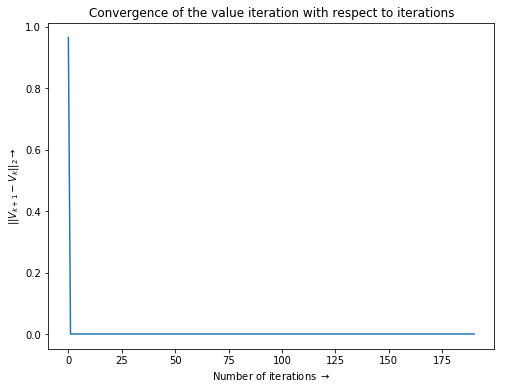

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(value_iters), error)
plt.xlabel(r'Number of iterations $\rightarrow$')
plt.ylabel(r'$\vert\vert V_{k+1} - V_{k}\vert\vert_{2} \rightarrow$')
plt.title(r'Convergence of the value iteration with respect to iterations')
plt.show()

## Optimal Value function and Optimal Q-values

In [9]:
print('Optimal value function is:')
print(value_function)
print('\n')
q_val = value_function_to_Qvalues(env, gamma, value_function)
print('Optimal Q-values are:')
print(q_val)

Optimal value function is:
[6.88909050e-02 6.14145717e-02 7.44097623e-02 5.58073218e-02
 9.18545400e-02 1.74094334e-10 1.12208207e-01 8.86645034e-10
 1.45436355e-01 2.47496955e-01 2.99617593e-01 3.70784207e-11
 2.04739640e-10 3.79935901e-01 6.39020148e-01 1.66046515e-10]


Optimal Q-values are:
[[6.88909050e-02 6.66480050e-02 6.66480050e-02 5.97589145e-02]
 [3.90916431e-02 4.29902003e-02 4.07473003e-02 6.14145717e-02]
 [7.44097623e-02 6.88290301e-02 7.27275873e-02 5.74894968e-02]
 [3.90651255e-02 3.90651255e-02 3.34843933e-02 5.58073218e-02]
 [9.18545400e-02 7.11872685e-02 6.42981780e-02 4.82236336e-02]
 [1.56684901e-10 1.56684901e-10 1.56684901e-10 1.56684901e-10]
 [1.12208207e-01 8.98852782e-02 1.12208207e-01 2.23229290e-02]
 [7.97980531e-10 7.97980531e-10 7.97980531e-10 7.97980531e-10]
 [7.11872685e-02 1.17879993e-01 1.01805448e-01 1.45436355e-01]
 [1.57611677e-01 2.47496955e-01 2.03866048e-01 1.33516184e-01]
 [2.99617593e-01 2.65955131e-01 2.25368507e-01 1.07911549e-01]
 [3.3370578

## Optimal Policy
* Print the optimal policy which tells the agents what action take based on the current position of the game and optimal value function. 
* We will aslo plot the output in fancy manner to get more better idea. 

In [10]:
# Print the policy
print("Policy:") 
policy = value_function_to_policy(env, gamma, value_function)
policy_str = print_policy(policy, action_names)

Policy:
['LEFT' 'UP' 'LEFT' 'UP' 'LEFT' 'LEFT' 'RIGHT' 'LEFT' 'UP' 'DOWN' 'LEFT'
 'LEFT' 'LEFT' 'RIGHT' 'DOWN' 'LEFT']


Value Function [6.88909050e-02 6.14145717e-02 7.44097623e-02 5.58073218e-02
 9.18545400e-02 1.74094334e-10 1.12208207e-01 8.86645034e-10
 1.45436355e-01 2.47496955e-01 2.99617593e-01 3.70784207e-11
 2.04739640e-10 3.79935901e-01 6.39020148e-01 1.66046515e-10]
Policy [0 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]


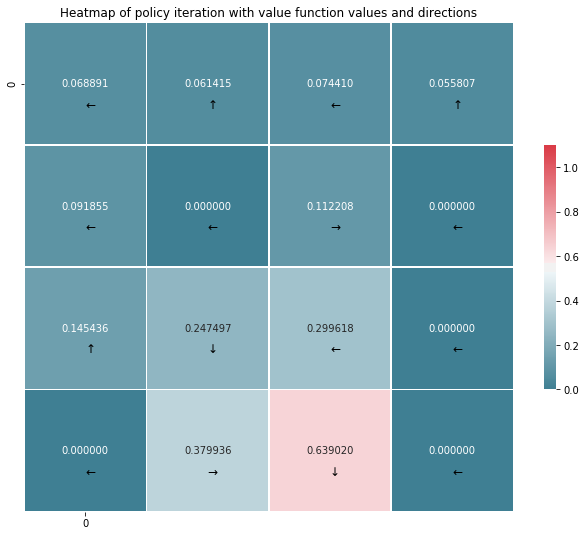

In [11]:
# Plot the policy
fancy_visual(value_function, policy)

In [12]:
# Plot
ps=[]
for elem in policy_str:
    ps.append(elem[0])
reshaped_policy=np.reshape(ps,(4,4))
# print(tabulate(reshaped_policy,tablefmt='latex'))
print('Above policy can also be expressed in a tabular form as follows:')
print(tabulate(reshaped_policy))

Above policy can also be expressed in a tabular form as follows:
-  -  -  -
L  U  L  U
L  L  R  L
U  D  L  L
L  R  D  L
-  -  -  -


## Performance measure

In [13]:
total_cum_reward=0
maxn = 5
start_time=time.time()
for n in range(maxn):
    cum_reward, nsteps = run_policy(env, gamma, policy)
    total_cum_reward += cum_reward
    if n%1 == 0: 
        print("Done " + str(n)) 
print("Time: " + str((time.time()-start_time)/60))
print("No. of steps for the last run: " + str(nsteps)) 
print("Performance of the agent over " + str(maxn) + " episodes")
print("Average Cumulative Reward: " + str((total_cum_reward/maxn))) 

Done 0
Done 1
Done 2
Done 3
Done 4
Time: 0.0003174146016438802
No. of steps for the last run: 37
Performance of the agent over 5 episodes
Average Cumulative Reward: 0.01682491014970692
